### Import libraries and create DataFrame from csv 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prompt user for week selection
start_week = int(input("Enter the start week for analysis: "))
end_week = int(input("Enter the end week for analysis (enter the same as start week for single week analysis): "))

# Function to read, preprocess, group by player, and aggregate data for the selected weeks
def read_and_aggregate_weekly_data(start_week, end_week):
    aggregated_data = pd.DataFrame()

    for week in range(start_week, end_week + 1):
        temp_df = pd.read_excel("RB_Data.xlsx", sheet_name=f"Week{week}")

        # Preprocess: Drop irrelevant columns and convert data types
        temp_df.drop(['FL', 'ROST'], axis=1, inplace=True)
        convert = temp_df.select_dtypes('object').columns.difference(['Player'])
        temp_df[convert] = temp_df[convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce')).fillna(0)
        temp_df['Rank'] = temp_df['Rank'].astype('Int64')

        # Group by 'Player' and aggregate data
        if aggregated_data.empty:
            aggregated_data = temp_df
        else:
            aggregated_data = aggregated_data.merge(temp_df, on='Player', suffixes=('', '_week' + str(week)))

    # Apply custom aggregation logic
    for column in aggregated_data.columns:
        if column.endswith(tuple([f'_week{week}' for week in range(start_week + 1, end_week + 1)])):
            base_column = column.split('_week')[0]
            if base_column in ['Rank', 'Player']:  # Take the latest value
                aggregated_data[base_column] = aggregated_data[column]
            elif base_column in ['LG']:  # Take the maximum value
                aggregated_data[base_column] = aggregated_data[[base_column, column]].max(axis=1)
            else:  # Sum the values
                aggregated_data[base_column] += aggregated_data[column]
            aggregated_data.drop(column, axis=1, inplace=True)  # Drop the extra week column

    # Calculate 'Y/A' and 'Y/R' based on summed values
    aggregated_data['Y/A'] = (aggregated_data['YDS'] / aggregated_data['ATT']).round(1)
    aggregated_data['Y/R'] = (aggregated_data['YDS.1'] / aggregated_data['REC']).round(1)
    aggregated_data['FPTS/G'] = (aggregated_data['FPTS'] / aggregated_data['G']).round(1)

    return aggregated_data

# Load and aggregate data for the selected weeks
df = read_and_aggregate_weekly_data(start_week, end_week)

# Recalculate 'Rank' based on 'FPTS' in descending order
df['Rank'] = df['FPTS'].rank(ascending=False, method='min').astype('int')

# Create 'Weeks' column
if start_week == end_week:
    df['Weeks'] = str(start_week)
else:
    df['Weeks'] = f"{start_week} - {end_week}"

df.sort_values(by='Rank').reset_index(drop=True).head(10)

,Rank,Player,ATT,YDS,Y/A,LG,20+,TD,REC,TGT,YDS.1,Y/R,TD.1,G,FPTS,FPTS/G,Weeks
0,1,Raheem Mostert (MIA),31,203,6.5,43,4,5,8,8,66,8.2,1,2,70.9,35.4,2 - 3
1,2,De'Von Achane (MIA),19,208,10.9,67,8,2,5,5,34,6.8,2,2,53.2,26.6,2 - 3
2,3,Kenneth Walker III (SEA),35,140,4.0,36,2,4,4,5,70,17.5,0,2,49.0,24.5,2 - 3
3,4,Christian McCaffrey (SF),38,201,5.3,51,4,2,8,8,53,6.6,0,2,45.4,22.7,2 - 3
4,5,Zack Moss (IND),48,210,4.4,24,2,1,6,7,42,7.0,1,2,43.2,21.6,2 - 3
5,5,Jerome Ford (CLE),26,124,4.8,69,4,1,5,7,58,11.6,2,2,43.2,21.6,2 - 3
6,7,D'Andre Swift (PHI),44,305,6.9,43,5,1,4,5,14,3.5,0,2,41.9,21.0,2 - 3
7,8,Kyren Williams (LAR),24,90,3.8,9,0,1,8,17,75,9.4,1,2,36.5,18.2,2 - 3
8,9,James Conner (ARI),37,204,5.5,26,4,2,2,3,18,9.0,0,2,36.2,18.1,2 - 3
9,10,Brian Robinson Jr. (WAS),28,157,5.6,27,2,2,2,3,42,21.0,0,2,35.9,18.0,2 - 3


### Check the data types of the columns

In [2]:
df.dtypes

Rank        int64
Player     object
ATT         int64
YDS         int64
Y/A       float64
LG          int64
20+         int64
TD          int64
REC         int64
TGT         int64
YDS.1       int64
Y/R       float64
TD.1        int64
G           int64
FPTS      float64
FPTS/G    float64
Weeks      object
dtype: object

### Convert relevant stats to a per-game basis and create the final stats for analysis

In [3]:
# Define columns for per-game calculation
per_game = list(df.columns[2:])

# Define columns to exclude from the per-game calculation
exclude_per_game = ['Y/A', 'LG', 'Y/R', 'G', 'FPTS', 'FPTS/G', 'Weeks']

# Create columns and convert stats to a per-game basis for the defined columns, not those in the exclude list
for col in per_game:
    if col not in exclude_per_game:
        df[col + '/game'] = (df[col] / df['G']).round(1)

# Define final columns to be used for analysis, combines excluded and new per-game columns
final_columns = exclude_per_game + [col + '/game' for col in per_game if col not in exclude_per_game]

# Display final columns with 'Rank' and 'Player'
df[['Rank', 'Player'] + final_columns].head(10)

,Rank,Player,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
0,10,Brian Robinson Jr. (WAS),5.6,27,21.0,2,35.9,18.0,2 - 3,14.0,78.5,1.0,1.0,1.0,1.5,21.0,0.0
1,8,Kyren Williams (LAR),3.8,9,9.4,2,36.5,18.2,2 - 3,12.0,45.0,0.0,0.5,4.0,8.5,37.5,0.5
2,16,Saquon Barkley (NYG),3.7,16,4.8,1,27.2,27.2,2 - 3,17.0,63.0,0.0,1.0,6.0,7.0,29.0,1.0
3,7,D'Andre Swift (PHI),6.9,43,3.5,2,41.9,21.0,2 - 3,22.0,152.5,2.5,0.5,2.0,2.5,7.0,0.0
4,1,Raheem Mostert (MIA),6.5,43,8.2,2,70.9,35.4,2 - 3,15.5,101.5,2.0,2.5,4.0,4.0,33.0,0.5
5,5,Jerome Ford (CLE),4.8,69,11.6,2,43.2,21.6,2 - 3,13.0,62.0,2.0,0.5,2.5,3.5,29.0,1.0
6,4,Christian McCaffrey (SF),5.3,51,6.6,2,45.4,22.7,2 - 3,19.0,100.5,2.0,1.0,4.0,4.0,26.5,0.0
7,14,Rachaad White (TB),3.6,13,6.8,2,28.5,14.2,2 - 3,15.5,55.5,0.0,0.5,4.0,4.0,27.0,0.0
8,13,Bijan Robinson (ATL),5.4,19,9.4,2,31.2,15.6,2 - 3,14.5,78.5,0.0,0.0,4.0,5.5,37.5,0.0
9,5,Zack Moss (IND),4.4,24,7.0,2,43.2,21.6,2 - 3,24.0,105.0,1.0,0.5,3.0,3.5,21.0,0.5


### Calculate the correlations for the final stats across different conditions

In [4]:
# Define columns and columns to exclude for correlation calculation, from final columns
exclude_corr = ['FPTS/G', 'FPTS', 'G', 'Weeks']
corr_columns = [col for col in final_columns if col not in exclude_corr]

# Define a function to calculate correlations
def compute_correlations(dataframe, corr_columns):
    return dataframe[corr_columns].corrwith(dataframe['FPTS/G'])

# Compute correlations for various conditions
corr_all = compute_correlations(df, corr_columns)
corr_nonzero = compute_correlations(df[df['FPTS/G'] > 0], corr_columns)
corr_top50 = compute_correlations(df[df['Rank'] <= 50], corr_columns)
corr_top25 = compute_correlations(df[df['Rank'] <= 25], corr_columns)

# Compile all correlations into a DataFrame for comparison
df_corr = pd.DataFrame({
    'All Players': corr_all,
    'FPTS > 0': corr_nonzero,
    'Top 50 Players': corr_top50,
    'Top 25 Players': corr_top25
})

# Calculate the average correlation across the four conditions, adding 'Average' column to DataFrame
df_corr['Correlation'] = df_corr.mean(axis=1)

df_corr.round(2)

,All Players,FPTS > 0,Top 50 Players,Top 25 Players,Correlation
Y/A,0.42,0.39,0.41,0.56,0.45
LG,0.78,0.75,0.70,0.62,0.71
Y/R,0.28,0.28,0.31,0.21,0.27
ATT/game,0.81,0.77,0.61,0.31,0.62
YDS/game,0.86,0.84,0.74,0.57,0.75
20+/game,0.61,0.60,0.69,0.62,0.63
TD/game,0.75,0.75,0.72,0.76,0.75
REC/game,0.73,0.68,0.49,0.13,0.51
TGT/game,0.68,0.62,0.38,-0.12,0.39
YDS.1/game,0.71,0.67,0.55,0.29,0.56


### Assign the weights for the final stats

In [5]:
# Calculate R^2 for the 'Average' correlation, adding 'R^2' column to DataFrame
df_corr['R^2'] = df_corr['Correlation'] ** 2

# Define the calculation to assign weights
def weight_calc(row):
    if row['Correlation'] >= 0.69:
        return 1 + row['R^2']
    else:
        return 1
    
# Assign weights based on the given criteria, adding 'Weight' column to DataFrame
df_corr['Weight'] = df_corr.apply(weight_calc, axis=1)

# Display the new columns in the DataFrame
df_corr[['Correlation', 'R^2', 'Weight']].round(2)

,Correlation,R^2,Weight
Y/A,0.45,0.20,1.00
LG,0.71,0.51,1.51
Y/R,0.27,0.07,1.00
ATT/game,0.62,0.39,1.00
YDS/game,0.75,0.57,1.57
20+/game,0.63,0.40,1.00
TD/game,0.75,0.56,1.56
REC/game,0.51,0.26,1.00
TGT/game,0.39,0.15,1.00
YDS.1/game,0.56,0.31,1.00


### Multiply the assigned weights to the final stats

In [6]:
# Multiply each relevant column by its corresponding weight
for col in corr_columns:
    weight = df_corr.loc[col, 'Weight']
    df[col + '_weighted'] = (df[col] * weight).round(1)

# Extract the weighted columns
weight_columns = [col + '_weighted' for col in corr_columns]

# Display the new weighted stats columns
df[['Rank', 'Player', 'FPTS/G'] + weight_columns].head(10)

,Rank,Player,FPTS/G,Y/A_weighted,LG_weighted,Y/R_weighted,ATT/game_weighted,YDS/game_weighted,20+/game_weighted,TD/game_weighted,REC/game_weighted,TGT/game_weighted,YDS.1/game_weighted,TD.1/game_weighted
0,10,Brian Robinson Jr. (WAS),18.0,5.6,40.7,21.0,14.0,122.9,1.0,1.6,1.0,1.5,21.0,0.0
1,8,Kyren Williams (LAR),18.2,3.8,13.6,9.4,12.0,70.5,0.0,0.8,4.0,8.5,37.5,0.5
2,16,Saquon Barkley (NYG),27.2,3.7,24.1,4.8,17.0,98.6,0.0,1.6,6.0,7.0,29.0,1.0
3,7,D'Andre Swift (PHI),21.0,6.9,64.8,3.5,22.0,238.7,2.5,0.8,2.0,2.5,7.0,0.0
4,1,Raheem Mostert (MIA),35.4,6.5,64.8,8.2,15.5,158.9,2.0,3.9,4.0,4.0,33.0,0.5
5,5,Jerome Ford (CLE),21.6,4.8,104.0,11.6,13.0,97.1,2.0,0.8,2.5,3.5,29.0,1.0
6,4,Christian McCaffrey (SF),22.7,5.3,76.8,6.6,19.0,157.3,2.0,1.6,4.0,4.0,26.5,0.0
7,14,Rachaad White (TB),14.2,3.6,19.6,6.8,15.5,86.9,0.0,0.8,4.0,4.0,27.0,0.0
8,13,Bijan Robinson (ATL),15.6,5.4,28.6,9.4,14.5,122.9,0.0,0.0,4.0,5.5,37.5,0.0
9,5,Zack Moss (IND),21.6,4.4,36.2,7.0,24.0,164.4,1.0,0.8,3.0,3.5,21.0,0.5


### Display the columns potentially to be included in the average weighted score

In [7]:
high_corr = df_corr[df_corr['Correlation'] >= 0.69].index.tolist()
conditional_columns = [col + '_weighted' for col in high_corr if col + '_weighted' in df.columns]

# Include 'FPTS/G' in columns to be used for the average weighted score
conditional_columns.append('FPTS/G')

conditional_columns

['LG_weighted', 'YDS/game_weighted', 'TD/game_weighted', 'FPTS/G']

### Define the columns to be used for the average weighted score

In [8]:
# Define select columns to be used for the average weighted score
avg = ['ATT/game_weighted',
 'YDS/game_weighted',
 'TD/game_weighted',
 'REC/game_weighted',
 'TGT/game_weighted',
 'YDS.1/game_weighted',
 'FPTS/G']

### Calculate each player's average weighted score and rank them from high to low

In [9]:
# Calculate the average weighted score for the select columns
df['Score'] = df[avg].mean(axis=1).round(1)

# Rank both of the average weighted scores with NaN handling
df['Final Rank'] = df.sort_values('Score', ascending=False)\
                ['Score'].rank(method='first', ascending=False, na_option='bottom').astype(int)

# Calculate the variance in ranking both ranks
df['Variance'] = df['Rank'] - df['Final Rank']

### Display results of the average weighted score and rank

In [10]:
# Display the results for the select columns
analysis = df[['Rank', 'Final Rank', 'Player', 'Score', 'Variance']]
analysis.set_index('Rank', inplace=True)
analysis.sort_values(by='Final Rank', ascending=True).head(30)

,Final Rank,Player,Score,Variance
Rank,,,,
7,1,D'Andre Swift (PHI),42.0,6
1,2,Raheem Mostert (MIA),36.4,-1
5,3,Zack Moss (IND),34.0,2
12,4,James Cook (BUF),33.9,8
4,5,Christian McCaffrey (SF),33.6,-1
2,6,De'Von Achane (MIA),31.8,-4
11,7,Tony Pollard (DAL),31.7,4
9,8,James Conner (ARI),29.9,1
13,9,Bijan Robinson (ATL),28.6,4


### Compare per-game stats of two players and visualize the results

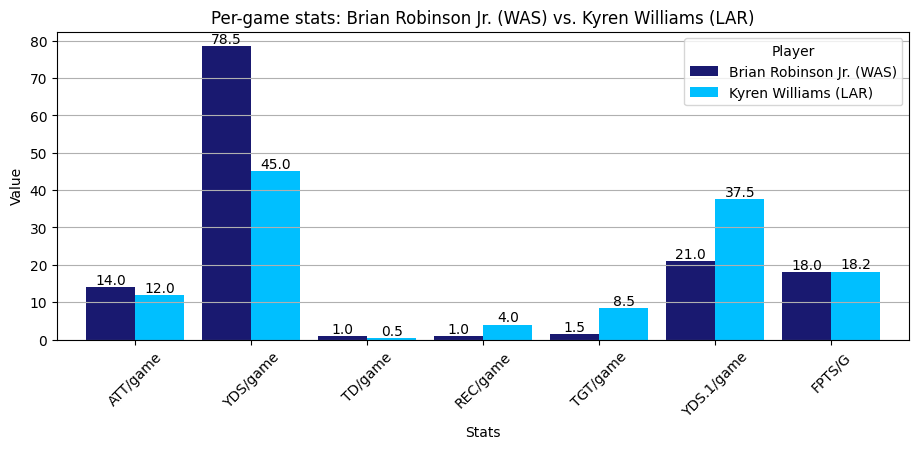

,Final Rank,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
Player,,,,,,,,,,,,,,,,
Brian Robinson Jr. (WAS),12,5.6,27,21.0,2,35.9,18.0,2 - 3,14.0,78.5,1.0,1.0,1.0,1.5,21.0,0.0
Kyren Williams (LAR),18,3.8,9,9.4,2,36.5,18.2,2 - 3,12.0,45.0,0.0,0.5,4.0,8.5,37.5,0.5


In [11]:
# Prompt the user to input the name of the players
player1 = input("Enter player 1 name")
player2 = input("Enter player 2 name")

# Extract and reorder rows for the two specified players
# Filter rows where the 'Player' column contains the names entered by the user
players = df[df['Player'].str.contains(player1) | df['Player'].str.contains(player2)]
players.set_index('Player', inplace=True)
player1_match = players.index[0] if player1 in players.index[0] else players.index[1]
player2_match = players.index[1] if player2 in players.index[1] else players.index[0]
players = players.reindex([player1_match, player2_match])

# Define columns to be compared
compare_columns = [col.replace('_weighted', '') for col in avg]

# Define a function to compare per-game stats of two players
def compare(player1, player2):

    # Plot the data
    chart = players[compare_columns].T.plot(kind='bar',
                                            color=['midnightblue', 'deepskyblue'],
                                            width=0.85,
                                            figsize=(11,4))

    # Format chart
    plt.title(f'Per-game stats: {player1} vs. {player2}')
    plt.xlabel('Stats')
    plt.ylabel('Value')
    plt.grid(axis='y')
    plt.xticks(rotation=45)

    # Add data labels above the bars
    for p in chart.patches:
        chart.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')

    plt.show()

# Call the 'compare' function which creates and displays the visualization
compare(player1_match, player2_match)
players[['Final Rank'] + final_columns]